<a href="https://colab.research.google.com/github/YasminUt/Code_/blob/main/CodeExemple_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("TensorFlow GPU availability:", tf.test.is_gpu_available())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.17.0
TensorFlow GPU availability: True


In [ ]:
import sys
print(sys.version)


3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [ ]:
#---------------------------------------------------------------------------------
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.25
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
#------------------------------------------------------------------------------
# Define the strategy for distributed training
strategy = tf.distribute.MirroredStrategy()
#------------------------------------------------------------------------------
# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print("GPU is available.")
else:
    print("No GPU available. Using CPU.")
#------------------------------------------------------------------------------
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


GPU is available.
Num GPUs Available:  1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
#------------------------------------------------------------------------------
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import models, layers
from glob import glob
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Input
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Input, Reshape, multiply
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelBinarizer
#------------------------------------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Training Configuration:
batch_size = 32
image_size =224
channels= 3
epochs =15

In [ ]:
#----------------------------------NormalyLoaddata--------------------------------------------
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size
)

Found 3000 files belonging to 3 classes.


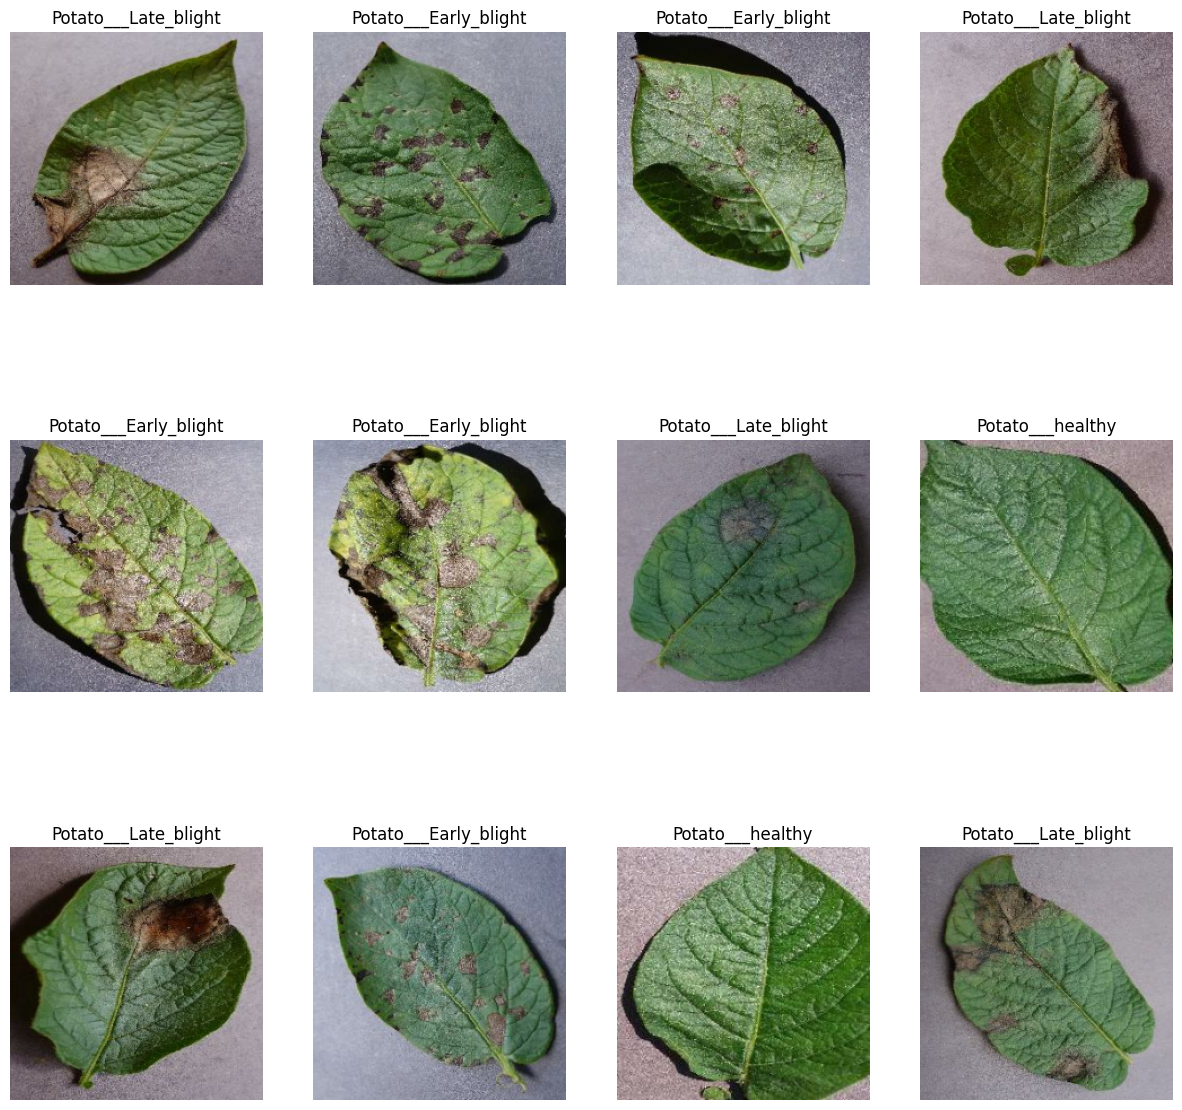

In [ ]:
#--------------------------------Image_Visualisation-----------------------------------
class_names = dataset.class_names
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
# Create a dictionary to map integer labels to class names
label_to_class = {i: class_name for i, class_name in enumerate(class_names)}

# Print the labels assigned to each class
for label, class_name in label_to_class.items():
    print(f"Label {label}: {class_name}")


Label 0: Potato___Early_blight
Label 1: Potato___Late_blight
Label 2: Potato___healthy


## **Data Spliting**

In [ ]:
## Get dataset splits and corresponding labels
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
#-------------------------------------------------------------------------------
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
#-------------------------------------------------------------------------------

In [ ]:
#Extract the number of classes
num_classes = len(dataset.class_names)
print("Number of classes:", num_classes)

Number of classes: 3


In [ ]:
input_shape = (image_size, image_size, channels)

## Transfer Learning

In [ ]:
# Define EfficientNet model
Efficientnet_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze EfficientNetB0 layers
for layer in Efficientnet_model.layers:
    layer.trainable = False

# Define a new input layer
input_layer = Input(shape=input_shape)
x = Efficientnet_model(input_layer)
#x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(num_classes, activation='softmax')(x)
#---------------------------------------------------------------------------------
# Create the EfficientNet-based model
Efficient_model = Model(inputs=input_layer, outputs=x)
#---------------------------------------------------------------------------------
# Compile the model
Efficient_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Print model summary
Efficient_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │         188,163 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,237,734 (16.17 MB)

 Trainable params: 188,163 (735.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
#---------------------------------------------------------------------------------
# Train the model
history_efficient = Efficient_model.fit(
    train_ds,
    batch_size=batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 635s 391ms/step - accuracy: 0.8492 - loss: 0.7680 - val_accuracy: 0.9722 - val_loss: 0.1773
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 207ms/step - accuracy: 0.9814 - loss: 0.1026 - val_accuracy: 0.9893 - val_loss: 0.0309
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.9918 - loss: 0.0363 - val_accuracy: 1.0000 - val_loss: 2.5958e-04
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9862 - loss: 0.0546 - val_accuracy: 0.9861 - val_loss: 0.1217
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - accuracy: 0.9919 - loss: 0.0408 - val_accuracy: 0.9965 - val_loss: 0.0063
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.9932 - loss: 0.0330 - val_accuracy: 0.9861 - val_loss: 0.0722
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - accuracy: 0.9943 - loss: 0.0290 - val_accuracy: 1.0000 - val_loss: 5.6782e-06
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.9956 - loss: 0.0118 -

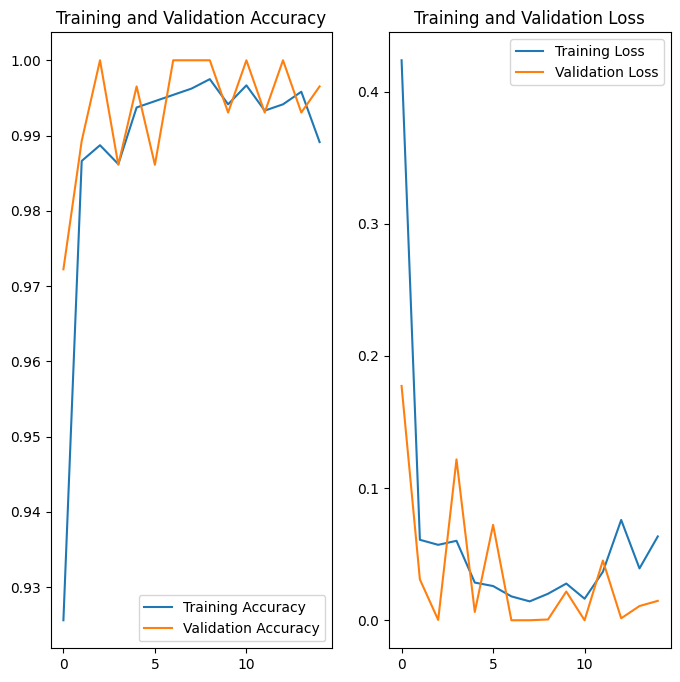

In [ ]:
acc = history_efficient.history['accuracy']
val_acc = history_efficient.history['val_accuracy']
loss = history_efficient.history['loss']
val_loss = history_efficient.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
#-----------------------Evaluation-----------------------------------------------
scores = Efficient_model.evaluate(test_ds)


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9957 - loss: 0.0066


In [ ]:
# Make predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = Efficient_model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_classes)
    y_true.extend(labels.numpy())



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
# Calculate and print the classification report
target_names = class_names
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))



                       precision    recall  f1-score   support

Potato___Early_blight     0.9810    1.0000    0.9904       103
 Potato___Late_blight     1.0000    0.9825    0.9912       114
     Potato___healthy     1.0000    1.0000    1.0000       103

             accuracy                         0.9938       320
            macro avg     0.9937    0.9942    0.9938       320
         weighted avg     0.9939    0.9938    0.9938       320



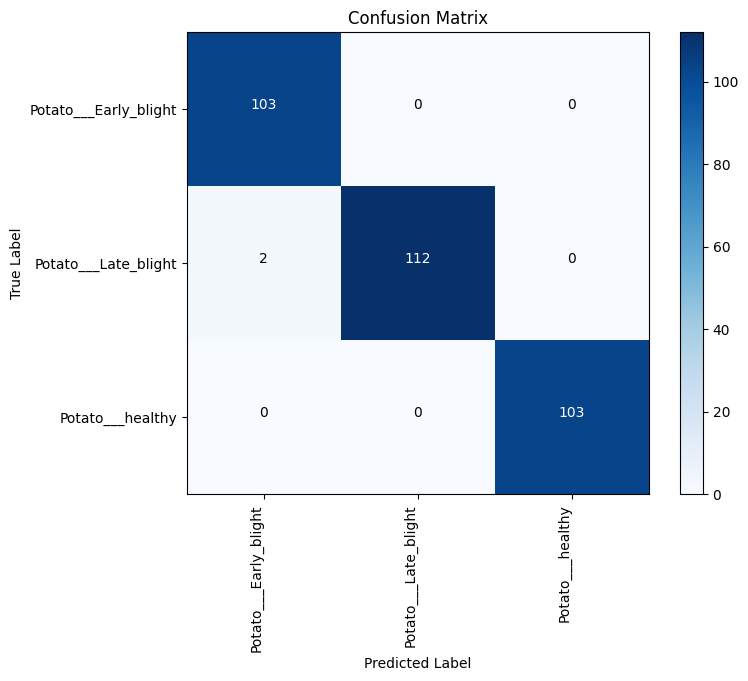

In [ ]:
# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with labeled counts
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90, ha='right')  # Rotate x-axis labels
plt.yticks(tick_marks, class_names)

# Print the counts inside the matrix
thresh = confusion_mtx.max() / 2.
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, format(confusion_mtx[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
predicted label: Potato___Early_blight


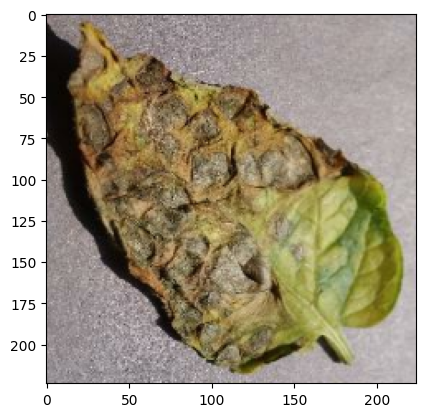

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = Efficient_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])